In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
%matplotlib inline
import torch
import os
from utils import *

## Test the different random $\alpha(P)$-profiles the PINN was trained on

Namely with:
- $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)} = 1$
- $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)} = 2$
- $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)}$ transitions from 1 to 2
- $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)}$ transitions from 2 to 1
- $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)}$ randomly switches between 1 and 2
- $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)} =$ random uniform distribution between 1 and 2

For each of these (except the random uniform), 2 different cases are considered:
- $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)}$ is exactly equal to 1 or 2
- $\frac{\mathrm{d \, log}(\alpha)}{\mathrm{d \, log} (P)}$ is distributed around 1 or 2 according to a truncated exponential probability distribution

(see utils.py for details)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
torch.set_num_threads(4)

model = torch.load("../models/HyperparameterSearch/IsothermalAtmoAlt_4x64_100x50_seed=3/TrainedModel/model.pkl", map_location=dev)

torch.set_num_threads(4)

In [3]:
keys = ["1", "2", "transition12", "transition21", "random-switch", "random-uniform"]

inputs = gen_test_samples(20, key=keys[2], smooth=False)

In [4]:
pinn_transm, prt_transm = calc_transm(model, inputs, calc_prt=True, mask=True)
print(pinn_transm.shape, prt_transm.shape)

radii, norm_radii = get_radii(inputs)
print(radii.shape)

torch.Size([20, 100]) torch.Size([20, 100])
torch.Size([20, 100])


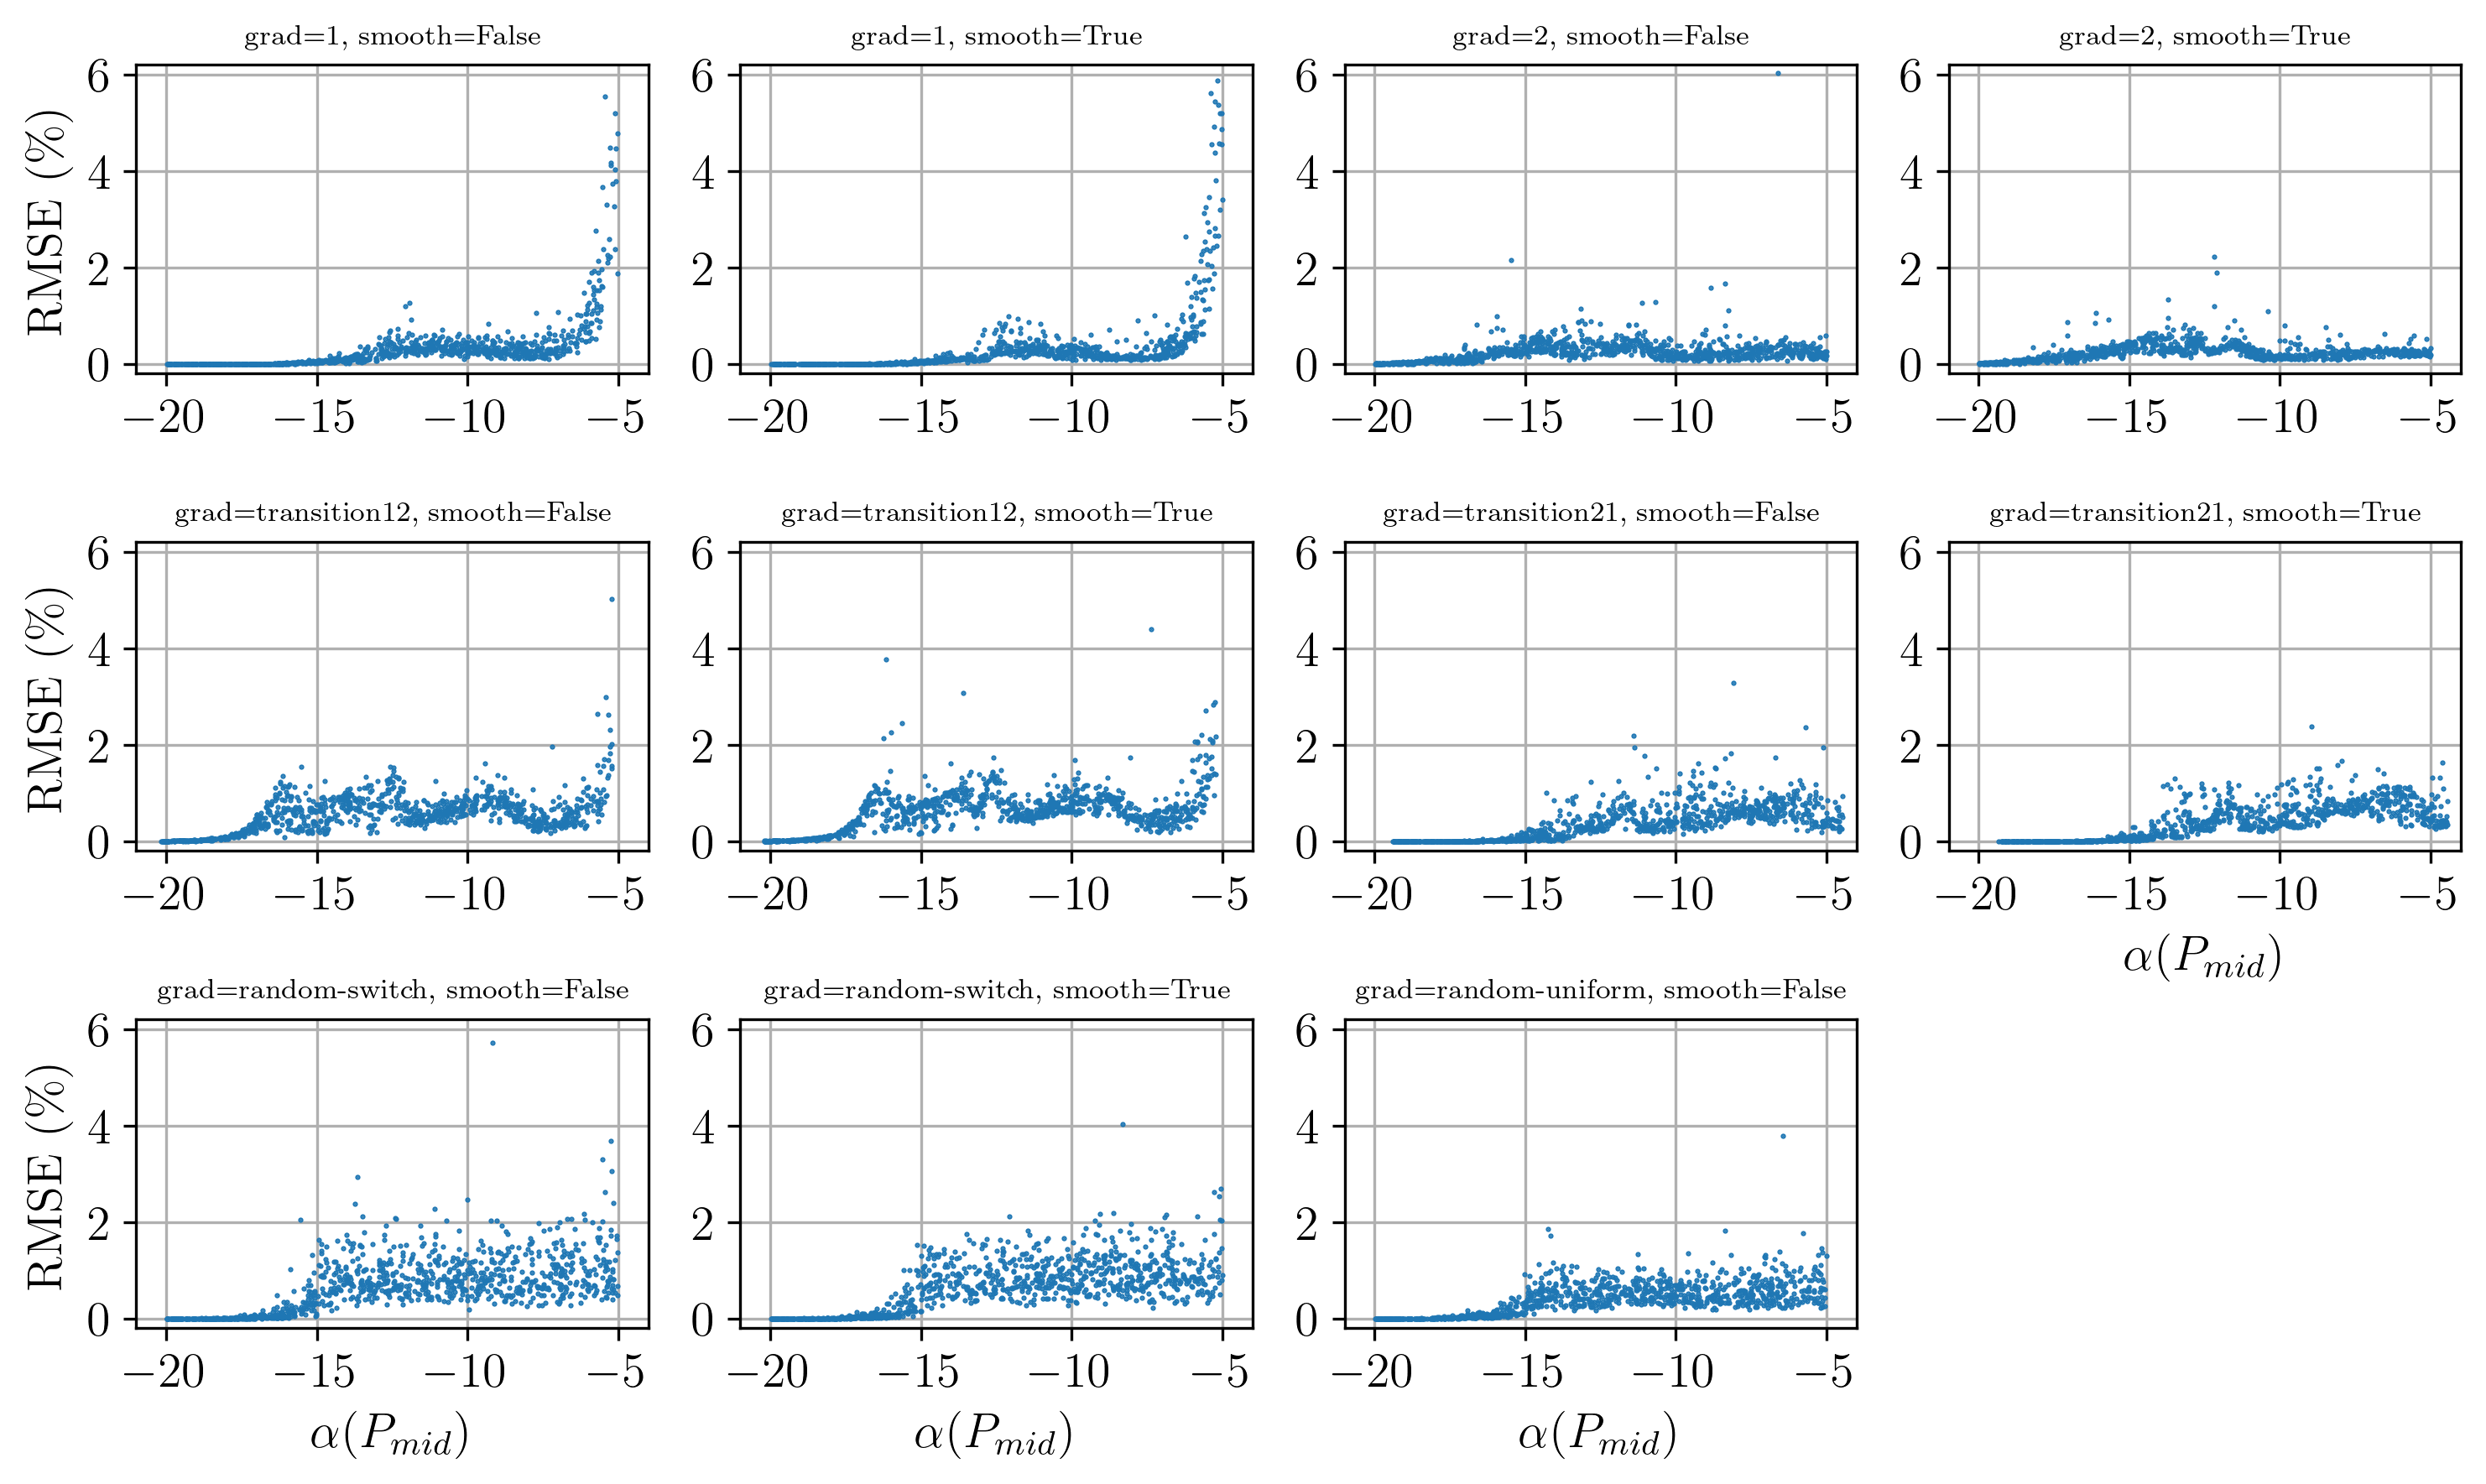

In [7]:
# Plot RMSE of transmission u(P), dependet on alpha at P_mid (P at layer #49)

n_samples = 1000

inputs = []
pinn_transm = []
prt_transm = []
errors = []

fig, axes = plt.subplots(3,4, figsize=(10,6))
axes = axes.flatten()

for i in range(len(keys)):
    for j in range(2):
        if i+j == len(keys):
            break
        else:
            inp = gen_test_samples(n_samples, key=keys[i], smooth=j, R02=True)
            inputs.append(inp)
            
            pinn_pred, true_transm = calc_transm(model, inp, calc_prt=True, mask=True)
            pinn_transm.append(pinn_pred)
            prt_transm.append(true_transm)
            
            error = pinn_pred - true_transm
            errors.append(error)
            mean_sq_error = torch.sqrt(torch.mean(abs(error)**2, dim=-1))
            
            mid_alphas = inp[:,4:][:,49]
            mid_alphas = (mid_alphas * mean_std_alpha[1,49]) + mean_std_alpha[0,49]
            
            axes[i*2+j].plot(mid_alphas, mean_sq_error*100, '.', markersize=1.0)
            axes[i*2+j].set_xlim(-21,-4)
            axes[i*2+j].set_xticks([-20,-15,-10,-5])
            axes[i*2+j].set_ylim(-0.2,6.2)
            axes[i*2+j].set_yticks([0,2,4,6])
            axes[i*2+j].grid()
            axes[i*2+j].set_title(f'grad={keys[i]}, smooth={bool(j)}', fontsize=8)
            
            if (i*2+j) % 4 == 0:
                axes[i*2+j].set_ylabel(r'RMSE (\%)')
            if (i*2+j) >= 7:
                axes[i*2+j].set_xlabel(r'$\alpha(P_{mid})$')

axes[-1].axis('off')

fig.tight_layout()

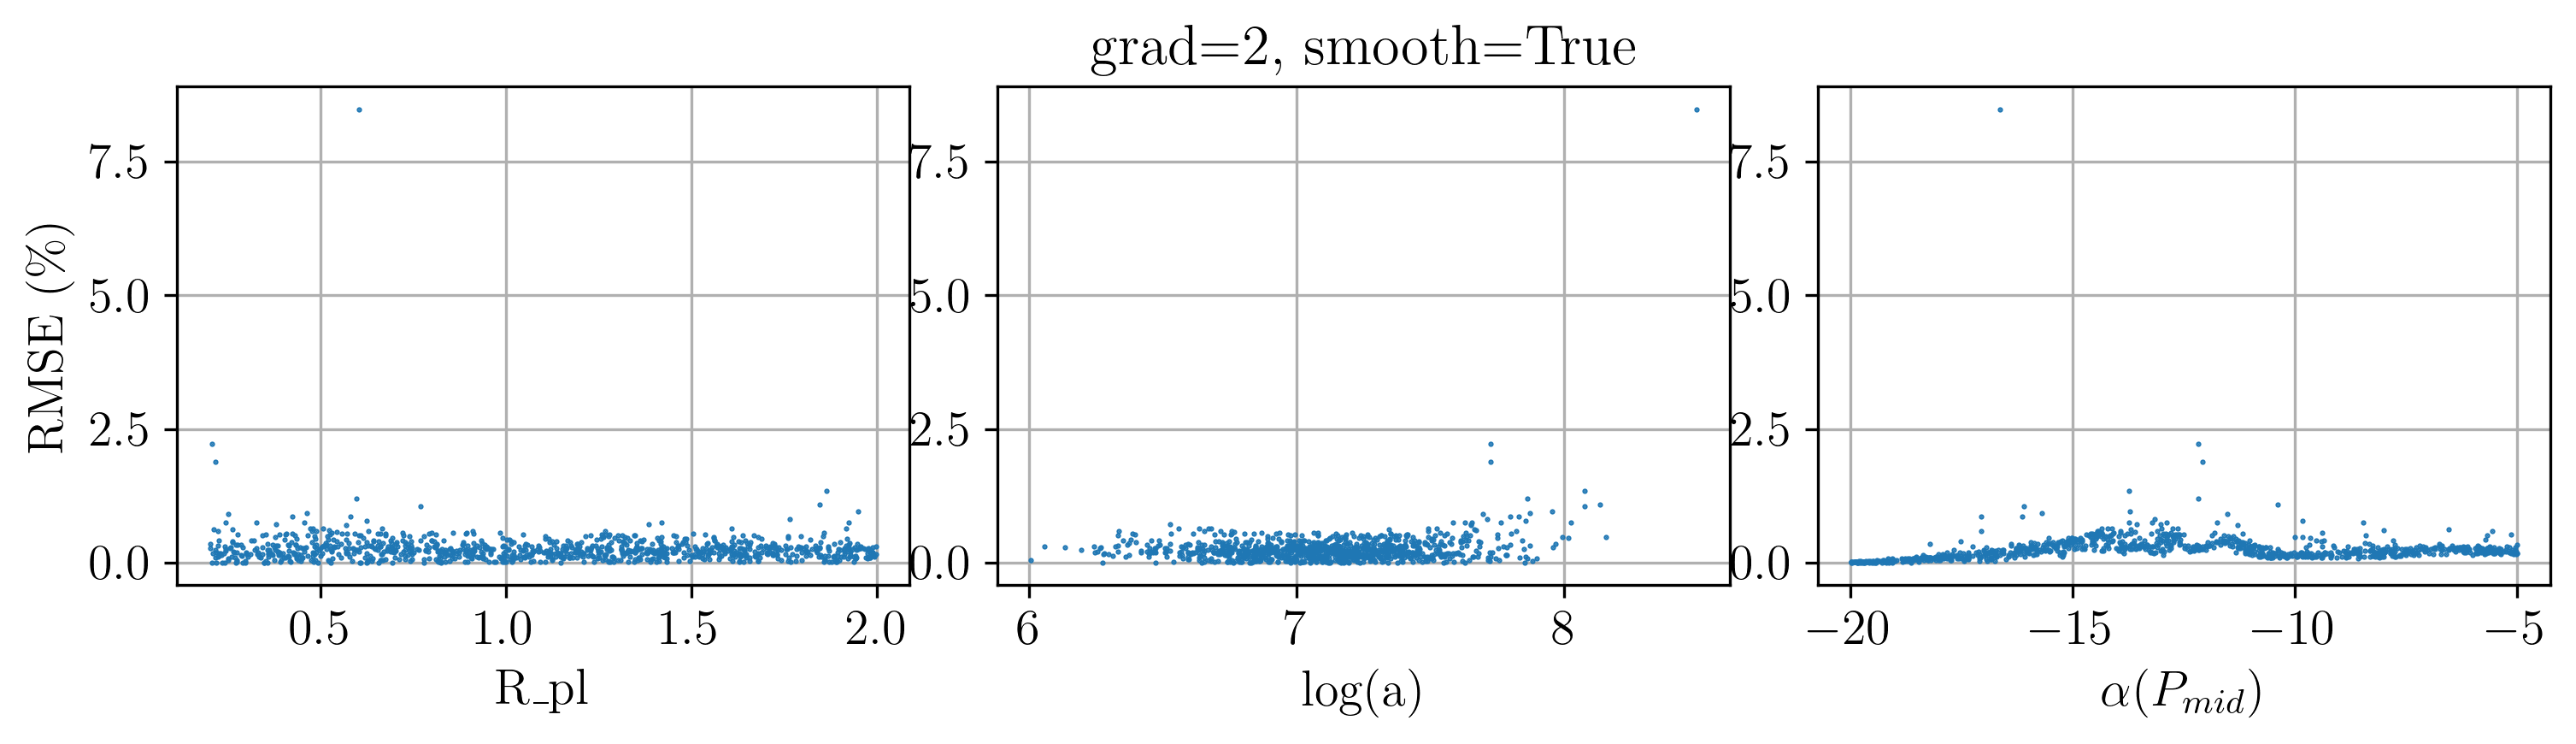

In [8]:
# Plot further dependence of RMSE on parameters radius R, log scale-height "a" and alpha(P_mid)
# of one sepcific kind of profile (set with ind)

ind = 3

xlabels = ['R_pl', 'log(a)', r'$\alpha(P_{mid})$']

mean_sq_error = torch.sqrt(torch.mean(abs(errors[ind])**2, dim=-1))
params = [inputs[ind][:,2], inputs[ind][:,3], inputs[ind][:,4:][:,49]]

params[0] = (params[0] * mean_std_Rpl[1]) + mean_std_Rpl[0]
params[1] = (params[1] * mean_std_a[1]) + mean_std_a[0]
params[2] = (params[2] * mean_std_alpha[1,49]) + mean_std_alpha[0,49]

fig, axes = plt.subplots(1,3, figsize=(10,3))
axes=axes.flatten()

for i in range(3):
    axes[i].plot(params[i], mean_sq_error*100, '.', markersize=1.0)
    axes[i].set_xlabel(xlabels[i])
    axes[i].grid()
    
axes[0].set_ylabel(r'RMSE (\%)')

axes[1].set_title(f'grad={keys[int(np.floor(ind/2))]}, smooth={bool(ind%2)}')
    
fig.tight_layout()